# 給食の献立提案(後半) - 量子アニーリングソリューションコンテスト

## 概要
2021/12/19に行われた[量子アニーリングソリューションコンテスト](http://www.tfc.tohoku.ac.jp/special/qca/20211218.html)に、T-QARD-949として参加しました。

<iframe width="560" height="315" src="https://www.youtube.com/embed/BqTC-FUMWc8" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

こちらの記事はCoQさんの記事の後半部になります。全体像については前半の記事をお読みください。

## 原理

## 自己組織化マップ

自己組織化マップ（Self-Organizing Map, SOM）はクラスタリングの手法の一つで、高次元のデータを二次元のマップに落とし込むことで、視覚的にクラスターを理解できるようにするアルゴリズムです。今回は食材の組み合わせが高次元のデータとなります。もともと献立に入っている料理と量子アニーラから得られた食材の組み合わせを同時に自己組織化マップに投影することで、メニューを提案します。

![自己組織化マップによる献立の提案](figures/fig4.png)

今回は主菜の部分を実装しました。これと副菜、汁物についても同様に自己組織化マップに投影することで、3つを組み合わせて献立を作成することができます。具体的な見方はのちほど説明します。

## 実験

今回のコードは[こちら](https://www.haya-programming.com/entry/2018/04/07/161249)を参考にしています。

まずは必要なライブラリをインストールします。

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install scikir-learn
!pip install somoclu

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from somoclu import Somoclu
from sklearn.decomposition import PCA

### データの加工

前半の記事で紹介した方法により得られた食材のリストと、自己組織化マップに投影するデータを読み出します。今回は仙台市の4月の献立のうち、主食のみ取り出します。

In [ ]:
!wget "https://raw.githubusercontent.com/T-QARD/t-wave/main/notebooks/CoQ/school_lunch_sendai.csv"
!wget "https://raw.githubusercontent.com/T-QARD/t-wave/main/notebooks/CoQ/samples.csv"

In [6]:
# 使用する食材のリスト
df_ans = pd.read_csv('samples.csv')

# 主食に使う部分だけを取り出す
dropped_columns = list(df_ans.iloc[:, 4:13].columns) + list(df_ans.iloc[:, 37:].columns)
df_ans.drop(columns=dropped_columns, inplace=True)
df_ans.head()

,焼く,炒める,揚げる,煮る,ごはん,麦ごはん,パン,麺類,鶏肉,豚肉,牛肉,ベーコン,ウインナー,かじき,えび,ホキ,さわら,ちくわ,赤魚,まぐろ,かつお,あさり,卵,うずら卵,みそ,大豆,豆腐,油揚げ
0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
# 自己組織化マップに投影するデータ
df_data = pd.read_csv('school_lunch_sendai.csv')

df_data = df_data[df_ans.columns]  # 主食に使う部分だけを取り出す
df_data.head()

,焼く,炒める,揚げる,煮る,ごはん,麦ごはん,パン,麺類,鶏肉,豚肉,牛肉,ベーコン,ウインナー,かじき,えび,ホキ,さわら,ちくわ,赤魚,まぐろ,かつお,あさり,卵,うずら卵,みそ,大豆,豆腐,油揚げ
0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0
1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0
2,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


次に、給食の献立データと量子アニーリングマシンから得られた解を一つにまとめます。

In [8]:
ans = df_ans.loc[2].values  # 量子アニーリングマシンから得られた解から一つ選ぶ
X = np.vstack([df_data.values, ans])

# 各データ(料理)にラベルとして数字を割り振る
y = np.arange(len(X))

### 自己組織化マップへの投影

最後に自己組織化マップに投影します。

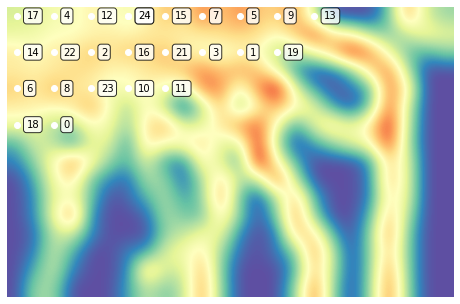

In [11]:
som = Somoclu(n_rows=16, n_columns=24, initialization="pca", verbose=3)
som.train(data=X, epochs=1000)

som.view_umatrix(labels=y, bestmatches=True, filename="umatrix.png")
plt.show()

明るい色ほどデータ間の距離は大きく、暗い色ほど小さいです。つまり、明るい色に囲まれた暗い部分に一緒に入っている点はクラスターと見なすことができ、データとして近くなっています（下図左上）

![主菜の自己組織化マップ](figures/fig5.png)

自己組織化マップの見方が合っているかどうか確かめるために、類似度の行列を表示します。

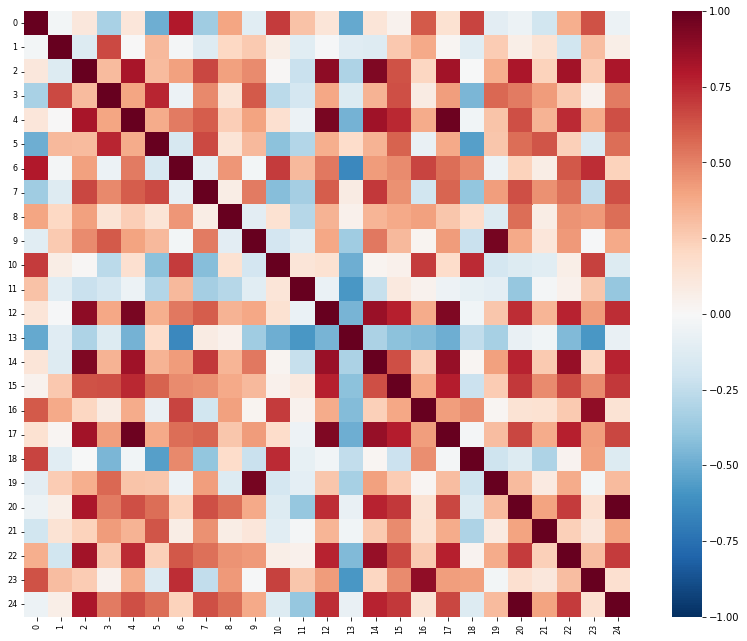

In [12]:
som.view_similarity_matrix(labels=y)
plt.show()

この結果の場合、カレーやシチューといった煮込む系の料理がクラスターとして同じところに属しており、正しく投影されていることがわかります。また、今回量子アニーリングマシンから得られた解として用いたのはリストの最後に加えた24番であるので、ポークカレーやビーフシチューが作れる可能性が高い食材の組み合わせになっています。

今回得られた結果は左上にデータが集まっていたので、その原因を明らかにする必要があります。また、最終的にはこれを副菜、汁物についてもおこなうことで給食全体の献立を提示することができます。アプリケーションとしての側面から見ると、今回は数字としてしか出力できなかったので、料理名を表示することでメニューをわかりやすくできるでしょう。

## あとがき

今回受賞することはできませんでしたが、量子アニーリングが社会の役に立たないか考え、さらに実際にプロダクトを作ってみるところまでやったというのは大変貴重な経験でした。同時にまだまだプログラミングについては実力不足であるなと痛感しました。また，自己組織化マップに対する理解も足りていませんでした。

現在自分は[量子アニーリングを用いた自己組織化マップについての論文](https://www.frontiersin.org/articles/10.3389/fphy.2018.00055/full)を読んでいるところです。読み終わった後にもう一度実装しなおしてみることで、今後の改善点としても挙げていた描画の問題等を解決し、よりよいソリューションにできたらいいなと考えています。

### 本記事の担当者

會田裕樹